In [1]:
import pickle
from werkzeug.contrib.cache import SimpleCache
cache = SimpleCache()

import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable
import cv2

import model
from model import RNN_ENCODER, G_NET, CNN_ENCODER, G_DCGAN, D_NET256
from miscc.utils import weights_init
from datasets import TextDataset, prepare_data
from miscc.utils import build_super_images, build_super_images2

/home/hanSolo/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 'werkzeug.contrib.cache' is deprecated as of version 0.15 and will be removed in version 1.0. It has moved to https://github.com/pallets/cachelib.
  


In [2]:
netG = G_NET()
netG.apply(weights_init)
netG.cuda()
netG.eval()
#
text_encoder = RNN_ENCODER(27297, nhidden=256)
state_dict = \
    torch.load('../models/text_encoder100.pth', map_location=lambda storage, loc: storage)
text_encoder.load_state_dict(state_dict)
text_encoder = text_encoder.cuda()
text_encoder.eval()

state_dict = \
    torch.load('../models/coco_AttnGAN2.pth', map_location=lambda storage, loc: storage)
netG.load_state_dict(state_dict)

/home/hanSolo/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


<All keys matched successfully>

In [3]:
batch_size = 100

In [4]:
imsize = 64 * (2 ** (3 - 1))
image_transform = transforms.Compose([
    transforms.Resize(int(imsize * 76 / 64)),
    transforms.RandomCrop(imsize),
    transforms.RandomHorizontalFlip()])

dataset = TextDataset('../data/coco/', 'test',
                      base_size=64,
                      transform=image_transform)
assert dataset
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size,
    drop_last=True, shuffle=True, num_workers=12)

Load filenames from: ../data/coco//train/filenames.pickle (82783)
Load filenames from: ../data/coco//test/filenames.pickle (40470)
Load from:  ../data/coco/captions.pickle


In [5]:
wordtoix = dataset.wordtoix

In [6]:
def gen_img():
    output=[]
    '''generate images from example sentences'''
    from nltk.tokenize import RegexpTokenizer
    data_dic = {}


    sentences = ['There is a sun in the middle of the sky']
    # a list of indices for a sentence
    captions = []
    cap_lens = []
    for sent in sentences:
        if len(sent) == 0:
            continue
        sent = sent.replace("\ufffd\ufffd", " ")
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(sent.lower())
        if len(tokens) == 0:
            print('sent', sent)
            continue

        rev = []
        for t in tokens:
            t = t.encode('ascii', 'ignore').decode('ascii')
            if len(t) > 0 and t in wordtoix:
                rev.append(wordtoix[t])
        captions.append(rev)
        cap_lens.append(len(rev))
    max_len = np.max(cap_lens)

    sorted_indices = np.argsort(cap_lens)[::-1]
    cap_lens = np.asarray(cap_lens)
    cap_lens = cap_lens[sorted_indices]
    cap_array = np.zeros((len(captions), max_len), dtype='int64')
    for i in range(len(captions)):
        idx = sorted_indices[i]
        cap = captions[idx]
        c_len = len(cap)
        cap_array[i, :c_len] = cap
    data_dic[0] = [cap_array, cap_lens, sorted_indices]
    for key in data_dic:
        save_dir = 'op/'
        captions, cap_lens, sorted_indices = data_dic[key]

        batch_size = captions.shape[0]
        nz = 100

        with torch.no_grad():
            captions = Variable(torch.from_numpy(captions))
            cap_lens = Variable(torch.from_numpy(cap_lens))

            captions = captions.cuda()
            cap_lens = cap_lens.cuda()

        for i in range(1):  # 16
            with torch.no_grad():
                noise = Variable(torch.FloatTensor(batch_size, nz))
                noise = noise.cuda()
            #######################################################
            # (1) Extract text embeddings
            ######################################################
            hidden = text_encoder.init_hidden(batch_size)
            # words_embs: batch_size x nef x seq_len
            # sent_emb: batch_size x nef
            words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
            mask = (captions == 0)
            #######################################################
            # (2) Generate fake images
            ######################################################
            noise.data.normal_(0, 1)
            fake_imgs, attention_maps, _, _ = netG(noise, sent_emb, words_embs, mask)
            # G attention
            cap_lens_np = cap_lens.cpu().data.numpy()
            for j in range(batch_size):
                save_name = '%s/%d_s_%d' % (save_dir, i, sorted_indices[j])
                for k in range(len(fake_imgs)):
                    im = fake_imgs[k][j].data.cpu().numpy()
                    im = (im + 1.0) * 127.5
                    im = im.astype(np.uint8)
                    # print('im', im.shape)
                    im = np.transpose(im, (1, 2, 0))
                    # print('im', im.shape)
                    im = Image.fromarray(im)
                    fullpath = '%s_g%d.png' % (save_name, k)
                    output.append(im)

                for k in range(len(attention_maps)):
                    if len(fake_imgs) > 1:
                        im = fake_imgs[k + 1].detach().cpu()
                    else:
                        im = fake_imgs[0].detach().cpu()
                    attn_maps = attention_maps[k]
                    att_sze = attn_maps.size(2)
                    img_set, sentences = \
                        build_super_images2(im[j].unsqueeze(0),
                                            captions[j].unsqueeze(0),
                                            [cap_lens_np[j]], dataset.ixtoword,
                                            [attn_maps[j]], att_sze)
                    if img_set is not None:
                        im = Image.fromarray(img_set)
#                         fullpath = '%s_a%d.png' % (save_name, k)
                        output.append(im)
    return output

In [7]:
output = gen_img()

/mnt/D4567C46567C2AFE/Work HDD/Research/AI-Research/Words-Vision-AttnGAN/src/miscc/utils.py:239: RuntimeWarning: invalid value encountered in true_divide
  one_map = (one_map - minV) / (maxV - minV)


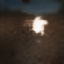

In [8]:
output[0]